In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from PIL import Image
import os
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math as math
import matplotlib.pyplot as plt

In [2]:
# Data Loading
DATA_PATH = "data/"

# Data & Augmentation
IMAGE_SIZE = 64
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Model
LATENT_SIZE = 128
MODEL_VERSION = "v1"
OLD_MODEL_EXISTS = True

# Training
NUM_IMAGES_TO_USE = 1000
START_INDEX = 64
BATCH_SIZE = 100
NUM_EPOCHS = 200
LEARNING_RATE = 0.0002

# Saving/Loading Model
MODEL_PATH = "model/" + MODEL_VERSION + "/"
SAMPLE_DIR = "generated/" + MODEL_VERSION + "/"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

Using device cpu


In [4]:
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(SAMPLE_DIR, exist_ok=True)

In [5]:
def pil_loader_rgba(path: str) -> Image.Image:
    with open(path, 'rb') as f:
        img = Image.open(f)
        background = Image.new("RGBA", img.size, "WHITE")
        alphaComposite = Image.alpha_composite(background, img)
        result = alphaComposite.convert("RGB")
        return result

In [6]:
real_dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=T.Compose([T.Resize(IMAGE_SIZE), 
T.CenterCrop(IMAGE_SIZE),
T.ToTensor(),
T.Normalize(*STATS)]))

real_dataset = Subset(real_dataset, range(NUM_IMAGES_TO_USE))

real_dataloader = DataLoader(real_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
def denormalize(img_tensors):
    return img_tensors *  STATS[1][0] + STATS[0][0]

def show_images(images, nmax=16):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:nmax]), nrow=8).permute(1,2,0))
    plt.show()

def show_batch(dl, nmax=16):
    for i, (images, _) in enumerate(dl):
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

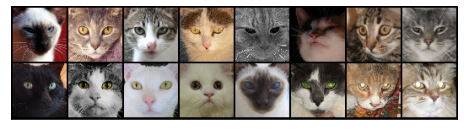

In [8]:
show_batch(real_dataloader)

In [9]:
discriminator = nn.Sequential(
    # in:  3 x 64 x 64

    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
).to(device)

In [10]:
generator = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1

    nn.ConvTranspose2d(in_channels=LATENT_SIZE, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    # 3 x 64 x 64
    nn.Tanh()
).to(device)

torch.Size([100, 3, 64, 64])


<Figure size 432x288 with 0 Axes>

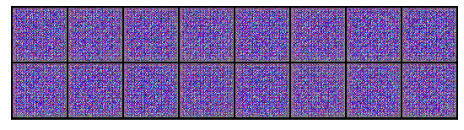

In [11]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [12]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score

In [13]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [14]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-image-{0:0=4d}.png".format(index)
    save_image(denormalize(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show and (index % 10 == 0):
       show_images(fake_images)

Saving generated-image-0000.png


<Figure size 432x288 with 0 Axes>

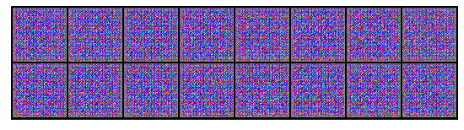

In [15]:
fixed_latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
save_samples(0, fixed_latent)

Epoch [1/200], Batch [1/10], loss_g: 8.5048, loss_d: 0.4960
Epoch [1/200], Batch [2/10], loss_g: 3.6194, loss_d: 2.6773
Epoch [1/200], Batch [3/10], loss_g: 3.3321, loss_d: 0.6564
Epoch [1/200], Batch [4/10], loss_g: 5.1804, loss_d: 0.5233
Epoch [1/200], Batch [5/10], loss_g: 4.2950, loss_d: 0.4492
Epoch [1/200], Batch [6/10], loss_g: 3.7347, loss_d: 0.4225
Epoch [1/200], Batch [7/10], loss_g: 5.6777, loss_d: 0.5946
Epoch [1/200], Batch [8/10], loss_g: 2.7952, loss_d: 0.7521
Epoch [1/200], Batch [9/10], loss_g: 4.8316, loss_d: 0.7977
Epoch [1/200], Batch [10/10], loss_g: 5.0559, loss_d: 0.3690
Saving generated-image-0065.png
Epoch [2/200], Batch [1/10], loss_g: 3.4307, loss_d: 0.3702
Epoch [2/200], Batch [2/10], loss_g: 4.6210, loss_d: 0.3780
Epoch [2/200], Batch [3/10], loss_g: 3.7381, loss_d: 0.3343
Epoch [2/200], Batch [4/10], loss_g: 4.9223, loss_d: 0.3149
Epoch [2/200], Batch [5/10], loss_g: 3.6372, loss_d: 0.3832
Epoch [2/200], Batch [6/10], loss_g: 5.6288, loss_d: 0.3889
Epoch [

<Figure size 432x288 with 0 Axes>

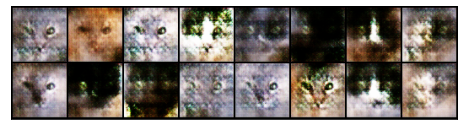

Epoch [7/200], Batch [1/10], loss_g: 5.8325, loss_d: 0.5506
Epoch [7/200], Batch [2/10], loss_g: 3.8105, loss_d: 0.2186
Epoch [7/200], Batch [3/10], loss_g: 7.1398, loss_d: 0.5798
Epoch [7/200], Batch [4/10], loss_g: 4.7376, loss_d: 0.6876
Epoch [7/200], Batch [5/10], loss_g: 4.9060, loss_d: 0.3603
Epoch [7/200], Batch [6/10], loss_g: 5.5164, loss_d: 0.2675
Epoch [7/200], Batch [7/10], loss_g: 3.9288, loss_d: 0.3919
Epoch [7/200], Batch [8/10], loss_g: 5.7507, loss_d: 0.5026
Epoch [7/200], Batch [9/10], loss_g: 5.4896, loss_d: 0.1950
Epoch [7/200], Batch [10/10], loss_g: 5.1971, loss_d: 0.3838
Saving generated-image-0071.png
Epoch [8/200], Batch [1/10], loss_g: 6.1758, loss_d: 0.4242
Epoch [8/200], Batch [2/10], loss_g: 4.3025, loss_d: 0.3647
Epoch [8/200], Batch [3/10], loss_g: 7.0013, loss_d: 0.3914
Epoch [8/200], Batch [4/10], loss_g: 4.5665, loss_d: 0.3641
Epoch [8/200], Batch [5/10], loss_g: 4.8419, loss_d: 0.2757
Epoch [8/200], Batch [6/10], loss_g: 6.9685, loss_d: 0.3056
Epoch [

<Figure size 432x288 with 0 Axes>

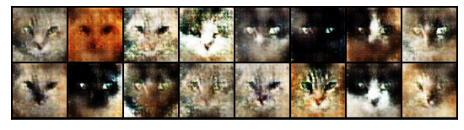

Epoch [17/200], Batch [1/10], loss_g: 1.8318, loss_d: 0.3971
Epoch [17/200], Batch [2/10], loss_g: 6.5295, loss_d: 1.5890
Epoch [17/200], Batch [3/10], loss_g: 6.9031, loss_d: 0.4165
Epoch [17/200], Batch [4/10], loss_g: 4.6755, loss_d: 0.3045
Epoch [17/200], Batch [5/10], loss_g: 4.4751, loss_d: 0.4948
Epoch [17/200], Batch [6/10], loss_g: 4.4506, loss_d: 0.5820
Epoch [17/200], Batch [7/10], loss_g: 4.1455, loss_d: 0.6224
Epoch [17/200], Batch [8/10], loss_g: 5.1810, loss_d: 0.4843
Epoch [17/200], Batch [9/10], loss_g: 4.5088, loss_d: 0.3544
Epoch [17/200], Batch [10/10], loss_g: 4.5353, loss_d: 0.4333
Saving generated-image-0081.png
Epoch [18/200], Batch [1/10], loss_g: 4.7402, loss_d: 0.4103
Epoch [18/200], Batch [2/10], loss_g: 5.0691, loss_d: 0.4689
Epoch [18/200], Batch [3/10], loss_g: 4.5252, loss_d: 0.3397
Epoch [18/200], Batch [4/10], loss_g: 4.3242, loss_d: 0.4245
Epoch [18/200], Batch [5/10], loss_g: 5.0433, loss_d: 0.4281
Epoch [18/200], Batch [6/10], loss_g: 3.9861, loss_d

<Figure size 432x288 with 0 Axes>

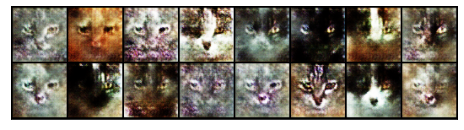

Epoch [27/200], Batch [1/10], loss_g: 5.3993, loss_d: 0.2203
Epoch [27/200], Batch [2/10], loss_g: 4.5364, loss_d: 0.2876
Epoch [27/200], Batch [3/10], loss_g: 6.5563, loss_d: 0.3915
Epoch [27/200], Batch [4/10], loss_g: 4.2793, loss_d: 0.3587
Epoch [27/200], Batch [5/10], loss_g: 5.7092, loss_d: 0.2949
Epoch [27/200], Batch [6/10], loss_g: 5.3126, loss_d: 0.1399
Epoch [27/200], Batch [7/10], loss_g: 5.0894, loss_d: 0.2185
Epoch [27/200], Batch [8/10], loss_g: 5.8958, loss_d: 0.2875
Epoch [27/200], Batch [9/10], loss_g: 4.5853, loss_d: 0.1932
Epoch [27/200], Batch [10/10], loss_g: 3.5530, loss_d: 0.2488
Saving generated-image-0091.png
Epoch [28/200], Batch [1/10], loss_g: 5.1958, loss_d: 0.2679
Epoch [28/200], Batch [2/10], loss_g: 7.7168, loss_d: 0.4865
Epoch [28/200], Batch [3/10], loss_g: 2.6118, loss_d: 0.9853
Epoch [28/200], Batch [4/10], loss_g: 8.2445, loss_d: 0.5966
Epoch [28/200], Batch [5/10], loss_g: 5.8622, loss_d: 0.3214
Epoch [28/200], Batch [6/10], loss_g: 4.4226, loss_d

<Figure size 432x288 with 0 Axes>

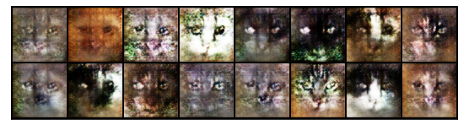

Epoch [37/200], Batch [1/10], loss_g: 4.7547, loss_d: 0.3058
Epoch [37/200], Batch [2/10], loss_g: 5.4275, loss_d: 0.2968
Epoch [37/200], Batch [3/10], loss_g: 4.5234, loss_d: 0.2215
Epoch [37/200], Batch [4/10], loss_g: 4.4136, loss_d: 0.2491
Epoch [37/200], Batch [5/10], loss_g: 5.3618, loss_d: 0.2511
Epoch [37/200], Batch [6/10], loss_g: 5.1582, loss_d: 0.2337
Epoch [37/200], Batch [7/10], loss_g: 4.3477, loss_d: 0.2656
Epoch [37/200], Batch [8/10], loss_g: 4.2058, loss_d: 0.1859
Epoch [37/200], Batch [9/10], loss_g: 5.1207, loss_d: 0.2244
Epoch [37/200], Batch [10/10], loss_g: 5.7643, loss_d: 0.2826
Saving generated-image-0101.png
Epoch [38/200], Batch [1/10], loss_g: 5.1722, loss_d: 0.2483
Epoch [38/200], Batch [2/10], loss_g: 3.0578, loss_d: 0.2838
Epoch [38/200], Batch [3/10], loss_g: 8.2118, loss_d: 0.4284
Epoch [38/200], Batch [4/10], loss_g: 3.8231, loss_d: 0.5275
Epoch [38/200], Batch [5/10], loss_g: 5.2532, loss_d: 0.1855
Epoch [38/200], Batch [6/10], loss_g: 5.5798, loss_d

<Figure size 432x288 with 0 Axes>

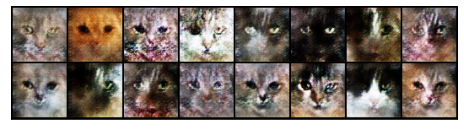

Epoch [47/200], Batch [1/10], loss_g: 9.4524, loss_d: 3.3435
Epoch [47/200], Batch [2/10], loss_g: 4.8254, loss_d: 0.2022
Epoch [47/200], Batch [3/10], loss_g: 5.0311, loss_d: 0.4839
Epoch [47/200], Batch [4/10], loss_g: 5.5614, loss_d: 0.2885
Epoch [47/200], Batch [5/10], loss_g: 3.4302, loss_d: 0.4040
Epoch [47/200], Batch [6/10], loss_g: 7.5538, loss_d: 0.7673
Epoch [47/200], Batch [7/10], loss_g: 4.1497, loss_d: 1.0535
Epoch [47/200], Batch [8/10], loss_g: 6.7460, loss_d: 0.7472
Epoch [47/200], Batch [9/10], loss_g: 5.3719, loss_d: 0.3766
Epoch [47/200], Batch [10/10], loss_g: 5.7890, loss_d: 0.3642
Saving generated-image-0111.png
Epoch [48/200], Batch [1/10], loss_g: 4.9294, loss_d: 0.3646
Epoch [48/200], Batch [2/10], loss_g: 5.5686, loss_d: 0.4446
Epoch [48/200], Batch [3/10], loss_g: 5.0682, loss_d: 0.3823
Epoch [48/200], Batch [4/10], loss_g: 6.2532, loss_d: 0.3926
Epoch [48/200], Batch [5/10], loss_g: 3.6159, loss_d: 0.4802
Epoch [48/200], Batch [6/10], loss_g: 9.6314, loss_d

<Figure size 432x288 with 0 Axes>

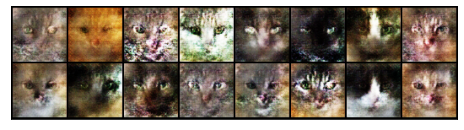

Epoch [57/200], Batch [1/10], loss_g: 3.7509, loss_d: 0.1593
Epoch [57/200], Batch [2/10], loss_g: 5.2792, loss_d: 0.5113
Epoch [57/200], Batch [3/10], loss_g: 4.7843, loss_d: 0.2366
Epoch [57/200], Batch [4/10], loss_g: 3.9954, loss_d: 0.3485
Epoch [57/200], Batch [5/10], loss_g: 4.2438, loss_d: 0.3171
Epoch [57/200], Batch [6/10], loss_g: 4.8809, loss_d: 0.3225
Epoch [57/200], Batch [7/10], loss_g: 4.4211, loss_d: 0.3176
Epoch [57/200], Batch [8/10], loss_g: 3.3056, loss_d: 0.4310
Epoch [57/200], Batch [9/10], loss_g: 5.6432, loss_d: 0.4446
Epoch [57/200], Batch [10/10], loss_g: 4.4367, loss_d: 0.2388
Saving generated-image-0121.png
Epoch [58/200], Batch [1/10], loss_g: 4.4047, loss_d: 0.1848
Epoch [58/200], Batch [2/10], loss_g: 4.7520, loss_d: 0.1600
Epoch [58/200], Batch [3/10], loss_g: 5.4324, loss_d: 0.3365
Epoch [58/200], Batch [4/10], loss_g: 3.6300, loss_d: 0.3629
Epoch [58/200], Batch [5/10], loss_g: 6.9761, loss_d: 0.5146
Epoch [58/200], Batch [6/10], loss_g: 3.5578, loss_d

<Figure size 432x288 with 0 Axes>

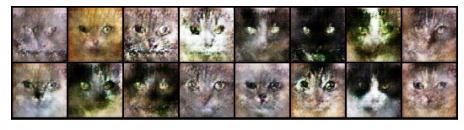

Epoch [67/200], Batch [1/10], loss_g: 4.9849, loss_d: 0.2608
Epoch [67/200], Batch [2/10], loss_g: 4.5433, loss_d: 0.1841
Epoch [67/200], Batch [3/10], loss_g: 6.0542, loss_d: 0.3246
Epoch [67/200], Batch [4/10], loss_g: 5.7439, loss_d: 0.4043
Epoch [67/200], Batch [5/10], loss_g: 3.5435, loss_d: 0.3538
Epoch [67/200], Batch [6/10], loss_g: 7.6429, loss_d: 0.4206
Epoch [67/200], Batch [7/10], loss_g: 6.5368, loss_d: 0.2187
Epoch [67/200], Batch [8/10], loss_g: 4.5162, loss_d: 0.1037
Epoch [67/200], Batch [9/10], loss_g: 4.8180, loss_d: 0.1531
Epoch [67/200], Batch [10/10], loss_g: 7.2069, loss_d: 0.3888
Saving generated-image-0131.png
Epoch [68/200], Batch [1/10], loss_g: 3.7765, loss_d: 0.4241
Epoch [68/200], Batch [2/10], loss_g: 7.2707, loss_d: 0.4281
Epoch [68/200], Batch [3/10], loss_g: 4.6840, loss_d: 0.3961
Epoch [68/200], Batch [4/10], loss_g: 4.0939, loss_d: 0.1800
Epoch [68/200], Batch [5/10], loss_g: 4.9507, loss_d: 0.1578
Epoch [68/200], Batch [6/10], loss_g: 6.8420, loss_d

<Figure size 432x288 with 0 Axes>

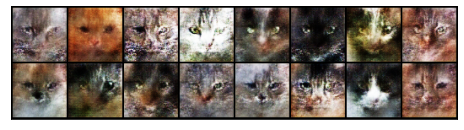

Epoch [77/200], Batch [1/10], loss_g: 5.5336, loss_d: 0.2700
Epoch [77/200], Batch [2/10], loss_g: 4.1281, loss_d: 0.2457
Epoch [77/200], Batch [3/10], loss_g: 4.7636, loss_d: 0.1959
Epoch [77/200], Batch [4/10], loss_g: 4.3823, loss_d: 0.1328
Epoch [77/200], Batch [5/10], loss_g: 4.6080, loss_d: 0.2496
Epoch [77/200], Batch [6/10], loss_g: 5.1223, loss_d: 0.2768
Epoch [77/200], Batch [7/10], loss_g: 3.1311, loss_d: 0.2718
Epoch [77/200], Batch [8/10], loss_g: 5.6453, loss_d: 0.2583
Epoch [77/200], Batch [9/10], loss_g: 4.2141, loss_d: 0.2258
Epoch [77/200], Batch [10/10], loss_g: 4.8975, loss_d: 0.1700
Saving generated-image-0141.png
Epoch [78/200], Batch [1/10], loss_g: 5.1243, loss_d: 0.1262
Epoch [78/200], Batch [2/10], loss_g: 4.1741, loss_d: 0.2271
Epoch [78/200], Batch [3/10], loss_g: 4.5735, loss_d: 0.1837
Epoch [78/200], Batch [4/10], loss_g: 5.9765, loss_d: 0.2252
Epoch [78/200], Batch [5/10], loss_g: 4.4715, loss_d: 0.2252
Epoch [78/200], Batch [6/10], loss_g: 4.4696, loss_d

<Figure size 432x288 with 0 Axes>

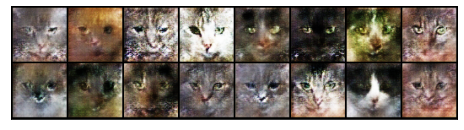

Epoch [87/200], Batch [1/10], loss_g: 4.9118, loss_d: 0.1197
Epoch [87/200], Batch [2/10], loss_g: 4.3076, loss_d: 0.2917
Epoch [87/200], Batch [3/10], loss_g: 4.5929, loss_d: 0.1648
Epoch [87/200], Batch [4/10], loss_g: 6.0614, loss_d: 0.3789
Epoch [87/200], Batch [5/10], loss_g: 4.1441, loss_d: 0.3358
Epoch [87/200], Batch [6/10], loss_g: 4.0328, loss_d: 0.2042
Epoch [87/200], Batch [7/10], loss_g: 5.2292, loss_d: 0.2415
Epoch [87/200], Batch [8/10], loss_g: 5.3273, loss_d: 0.2998
Epoch [87/200], Batch [9/10], loss_g: 4.3259, loss_d: 0.3179
Epoch [87/200], Batch [10/10], loss_g: 4.0779, loss_d: 0.1579
Saving generated-image-0151.png
Epoch [88/200], Batch [1/10], loss_g: 8.1227, loss_d: 0.5465
Epoch [88/200], Batch [2/10], loss_g: 6.4441, loss_d: 0.4189
Epoch [88/200], Batch [3/10], loss_g: 3.1003, loss_d: 0.2919
Epoch [88/200], Batch [4/10], loss_g: 5.5816, loss_d: 0.3557
Epoch [88/200], Batch [5/10], loss_g: 5.8980, loss_d: 0.1149
Epoch [88/200], Batch [6/10], loss_g: 4.6738, loss_d

<Figure size 432x288 with 0 Axes>

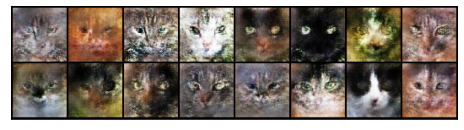

Epoch [97/200], Batch [1/10], loss_g: 3.8990, loss_d: 0.2207
Epoch [97/200], Batch [2/10], loss_g: 4.1954, loss_d: 0.2424
Epoch [97/200], Batch [3/10], loss_g: 6.9799, loss_d: 0.4510
Epoch [97/200], Batch [4/10], loss_g: 3.8080, loss_d: 0.4350
Epoch [97/200], Batch [5/10], loss_g: 4.5655, loss_d: 0.3005
Epoch [97/200], Batch [6/10], loss_g: 4.6638, loss_d: 0.1303
Epoch [97/200], Batch [7/10], loss_g: 5.5512, loss_d: 0.3430
Epoch [97/200], Batch [8/10], loss_g: 5.2151, loss_d: 0.2204
Epoch [97/200], Batch [9/10], loss_g: 3.5838, loss_d: 0.3119
Epoch [97/200], Batch [10/10], loss_g: 4.3590, loss_d: 0.2040
Saving generated-image-0161.png
Epoch [98/200], Batch [1/10], loss_g: 10.7895, loss_d: 0.9977
Epoch [98/200], Batch [2/10], loss_g: 7.1620, loss_d: 2.9242
Epoch [98/200], Batch [3/10], loss_g: 2.3702, loss_d: 0.3051
Epoch [98/200], Batch [4/10], loss_g: 7.6461, loss_d: 1.2082
Epoch [98/200], Batch [5/10], loss_g: 6.2737, loss_d: 0.4421
Epoch [98/200], Batch [6/10], loss_g: 4.6857, loss_

<Figure size 432x288 with 0 Axes>

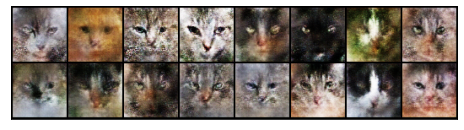

Epoch [107/200], Batch [1/10], loss_g: 5.6079, loss_d: 0.1513
Epoch [107/200], Batch [2/10], loss_g: 4.2207, loss_d: 0.2320
Epoch [107/200], Batch [3/10], loss_g: 6.8316, loss_d: 0.4834
Epoch [107/200], Batch [4/10], loss_g: 4.4009, loss_d: 0.4611
Epoch [107/200], Batch [5/10], loss_g: 3.4231, loss_d: 0.2083
Epoch [107/200], Batch [6/10], loss_g: 4.8145, loss_d: 0.2349
Epoch [107/200], Batch [7/10], loss_g: 5.4447, loss_d: 0.1094
Epoch [107/200], Batch [8/10], loss_g: 5.1495, loss_d: 0.3306
Epoch [107/200], Batch [9/10], loss_g: 4.6169, loss_d: 0.2780
Epoch [107/200], Batch [10/10], loss_g: 8.4484, loss_d: 0.6370
Saving generated-image-0171.png
Epoch [108/200], Batch [1/10], loss_g: 5.9886, loss_d: 0.6157
Epoch [108/200], Batch [2/10], loss_g: 4.2117, loss_d: 0.1183
Epoch [108/200], Batch [3/10], loss_g: 4.7640, loss_d: 0.1334
Epoch [108/200], Batch [4/10], loss_g: 6.8276, loss_d: 0.3075
Epoch [108/200], Batch [5/10], loss_g: 5.5549, loss_d: 0.2286
Epoch [108/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

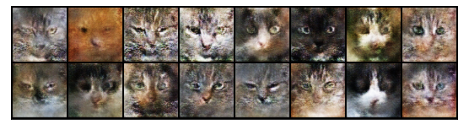

Epoch [117/200], Batch [1/10], loss_g: 11.4637, loss_d: 1.0004
Epoch [117/200], Batch [2/10], loss_g: 7.5382, loss_d: 3.4147
Epoch [117/200], Batch [3/10], loss_g: 3.4957, loss_d: 0.1185
Epoch [117/200], Batch [4/10], loss_g: 5.2155, loss_d: 0.4124
Epoch [117/200], Batch [5/10], loss_g: 5.3590, loss_d: 0.1936
Epoch [117/200], Batch [6/10], loss_g: 3.7796, loss_d: 0.3085
Epoch [117/200], Batch [7/10], loss_g: 4.5963, loss_d: 0.3025
Epoch [117/200], Batch [8/10], loss_g: 5.1395, loss_d: 0.2285
Epoch [117/200], Batch [9/10], loss_g: 3.8796, loss_d: 0.2794
Epoch [117/200], Batch [10/10], loss_g: 4.1647, loss_d: 0.3225
Saving generated-image-0181.png
Epoch [118/200], Batch [1/10], loss_g: 5.2938, loss_d: 0.3283
Epoch [118/200], Batch [2/10], loss_g: 4.3480, loss_d: 0.2455
Epoch [118/200], Batch [3/10], loss_g: 4.2117, loss_d: 0.2555
Epoch [118/200], Batch [4/10], loss_g: 5.0175, loss_d: 0.2754
Epoch [118/200], Batch [5/10], loss_g: 4.1979, loss_d: 0.1876
Epoch [118/200], Batch [6/10], loss_

<Figure size 432x288 with 0 Axes>

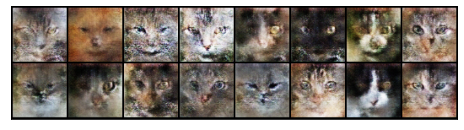

Epoch [127/200], Batch [1/10], loss_g: 4.8324, loss_d: 0.2718
Epoch [127/200], Batch [2/10], loss_g: 3.9584, loss_d: 0.1095
Epoch [127/200], Batch [3/10], loss_g: 4.5579, loss_d: 0.0903
Epoch [127/200], Batch [4/10], loss_g: 9.9352, loss_d: 0.6177
Epoch [127/200], Batch [5/10], loss_g: 5.3477, loss_d: 1.5746
Epoch [127/200], Batch [6/10], loss_g: 2.4345, loss_d: 0.1124
Epoch [127/200], Batch [7/10], loss_g: 9.1292, loss_d: 0.8186
Epoch [127/200], Batch [8/10], loss_g: 7.9406, loss_d: 0.3582
Epoch [127/200], Batch [9/10], loss_g: 4.6944, loss_d: 0.1427
Epoch [127/200], Batch [10/10], loss_g: 4.1589, loss_d: 0.1502
Saving generated-image-0191.png
Epoch [128/200], Batch [1/10], loss_g: 7.3639, loss_d: 0.3754
Epoch [128/200], Batch [2/10], loss_g: 5.8555, loss_d: 0.2418
Epoch [128/200], Batch [3/10], loss_g: 4.1138, loss_d: 0.1627
Epoch [128/200], Batch [4/10], loss_g: 4.5025, loss_d: 0.1142
Epoch [128/200], Batch [5/10], loss_g: 9.2994, loss_d: 0.7860
Epoch [128/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

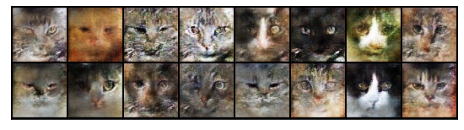

Epoch [137/200], Batch [1/10], loss_g: 7.3256, loss_d: 0.3385
Epoch [137/200], Batch [2/10], loss_g: 5.1125, loss_d: 0.3462
Epoch [137/200], Batch [3/10], loss_g: 2.9738, loss_d: 0.1774
Epoch [137/200], Batch [4/10], loss_g: 5.3312, loss_d: 0.2080
Epoch [137/200], Batch [5/10], loss_g: 4.8617, loss_d: 0.0999
Epoch [137/200], Batch [6/10], loss_g: 4.1652, loss_d: 0.1107
Epoch [137/200], Batch [7/10], loss_g: 4.3021, loss_d: 0.1595
Epoch [137/200], Batch [8/10], loss_g: 6.5593, loss_d: 0.3200
Epoch [137/200], Batch [9/10], loss_g: 4.5341, loss_d: 0.3105
Epoch [137/200], Batch [10/10], loss_g: 3.9092, loss_d: 0.0827
Saving generated-image-0201.png
Epoch [138/200], Batch [1/10], loss_g: 4.6051, loss_d: 0.0570
Epoch [138/200], Batch [2/10], loss_g: 9.8350, loss_d: 0.5615
Epoch [138/200], Batch [3/10], loss_g: 4.1757, loss_d: 1.4194
Epoch [138/200], Batch [4/10], loss_g: 3.3613, loss_d: 0.1996
Epoch [138/200], Batch [5/10], loss_g: 6.8371, loss_d: 0.3284
Epoch [138/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

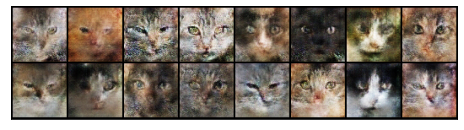

Epoch [147/200], Batch [1/10], loss_g: 8.3785, loss_d: 0.5217
Epoch [147/200], Batch [2/10], loss_g: 6.4277, loss_d: 0.2622
Epoch [147/200], Batch [3/10], loss_g: 5.2616, loss_d: 0.0913
Epoch [147/200], Batch [4/10], loss_g: 4.6891, loss_d: 0.0955
Epoch [147/200], Batch [5/10], loss_g: 6.2513, loss_d: 0.2651
Epoch [147/200], Batch [6/10], loss_g: 5.5907, loss_d: 0.1398
Epoch [147/200], Batch [7/10], loss_g: 3.8696, loss_d: 0.1463
Epoch [147/200], Batch [8/10], loss_g: 4.1617, loss_d: 0.1727
Epoch [147/200], Batch [9/10], loss_g: 4.3935, loss_d: 0.1107
Epoch [147/200], Batch [10/10], loss_g: 7.5269, loss_d: 0.3919
Saving generated-image-0211.png
Epoch [148/200], Batch [1/10], loss_g: 3.4426, loss_d: 0.7174
Epoch [148/200], Batch [2/10], loss_g: 4.9885, loss_d: 0.2771
Epoch [148/200], Batch [3/10], loss_g: 5.1686, loss_d: 0.0968
Epoch [148/200], Batch [4/10], loss_g: 4.9376, loss_d: 0.1207
Epoch [148/200], Batch [5/10], loss_g: 4.8585, loss_d: 0.0847
Epoch [148/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

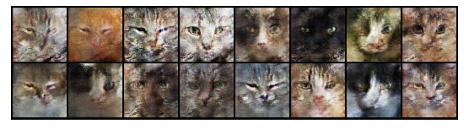

Epoch [157/200], Batch [1/10], loss_g: 3.9186, loss_d: 0.0702
Epoch [157/200], Batch [2/10], loss_g: 4.6598, loss_d: 0.0334
Epoch [157/200], Batch [3/10], loss_g: 12.8293, loss_d: 1.0230
Epoch [157/200], Batch [4/10], loss_g: 7.8739, loss_d: 3.1462
Epoch [157/200], Batch [5/10], loss_g: 2.8664, loss_d: 0.2061
Epoch [157/200], Batch [6/10], loss_g: 6.6856, loss_d: 0.6444
Epoch [157/200], Batch [7/10], loss_g: 5.8276, loss_d: 0.1812
Epoch [157/200], Batch [8/10], loss_g: 4.2863, loss_d: 0.1495
Epoch [157/200], Batch [9/10], loss_g: 5.7613, loss_d: 0.3248
Epoch [157/200], Batch [10/10], loss_g: 3.5413, loss_d: 0.3533
Saving generated-image-0221.png
Epoch [158/200], Batch [1/10], loss_g: 6.1582, loss_d: 0.3558
Epoch [158/200], Batch [2/10], loss_g: 4.2219, loss_d: 0.4070
Epoch [158/200], Batch [3/10], loss_g: 5.6571, loss_d: 0.3329
Epoch [158/200], Batch [4/10], loss_g: 5.2003, loss_d: 0.1126
Epoch [158/200], Batch [5/10], loss_g: 3.9313, loss_d: 0.2716
Epoch [158/200], Batch [6/10], loss_

<Figure size 432x288 with 0 Axes>

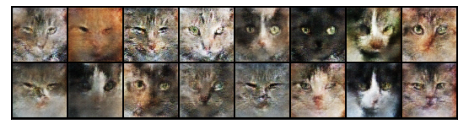

Epoch [167/200], Batch [1/10], loss_g: 6.1554, loss_d: 0.1233
Epoch [167/200], Batch [2/10], loss_g: 3.6722, loss_d: 0.2291
Epoch [167/200], Batch [3/10], loss_g: 4.3424, loss_d: 0.1130
Epoch [167/200], Batch [4/10], loss_g: 5.1754, loss_d: 0.0665
Epoch [167/200], Batch [5/10], loss_g: 5.8833, loss_d: 0.2130
Epoch [167/200], Batch [6/10], loss_g: 4.3116, loss_d: 0.2500
Epoch [167/200], Batch [7/10], loss_g: 3.3967, loss_d: 0.1327
Epoch [167/200], Batch [8/10], loss_g: 4.4254, loss_d: 0.0524
Epoch [167/200], Batch [9/10], loss_g: 8.9504, loss_d: 0.4222
Epoch [167/200], Batch [10/10], loss_g: 4.8019, loss_d: 0.9844
Saving generated-image-0231.png
Epoch [168/200], Batch [1/10], loss_g: 3.2040, loss_d: 0.0765
Epoch [168/200], Batch [2/10], loss_g: 6.0868, loss_d: 0.2312
Epoch [168/200], Batch [3/10], loss_g: 5.6267, loss_d: 0.1496
Epoch [168/200], Batch [4/10], loss_g: 3.3449, loss_d: 0.2920
Epoch [168/200], Batch [5/10], loss_g: 3.7700, loss_d: 0.0915
Epoch [168/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

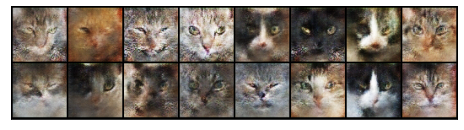

Epoch [177/200], Batch [1/10], loss_g: 7.3375, loss_d: 0.2413
Epoch [177/200], Batch [2/10], loss_g: 6.1188, loss_d: 0.1019
Epoch [177/200], Batch [3/10], loss_g: 7.3504, loss_d: 0.1016
Epoch [177/200], Batch [4/10], loss_g: 4.8040, loss_d: 0.0498
Epoch [177/200], Batch [5/10], loss_g: 4.3429, loss_d: 0.0633
Epoch [177/200], Batch [6/10], loss_g: 7.8048, loss_d: 0.3272
Epoch [177/200], Batch [7/10], loss_g: 6.9168, loss_d: 0.1804
Epoch [177/200], Batch [8/10], loss_g: 4.1510, loss_d: 0.1998
Epoch [177/200], Batch [9/10], loss_g: 4.2957, loss_d: 0.0416
Epoch [177/200], Batch [10/10], loss_g: 7.1702, loss_d: 0.2850
Saving generated-image-0241.png
Epoch [178/200], Batch [1/10], loss_g: 6.0191, loss_d: 0.1194
Epoch [178/200], Batch [2/10], loss_g: 4.2792, loss_d: 0.1557
Epoch [178/200], Batch [3/10], loss_g: 4.1403, loss_d: 0.0569
Epoch [178/200], Batch [4/10], loss_g: 5.5103, loss_d: 0.1540
Epoch [178/200], Batch [5/10], loss_g: 5.2610, loss_d: 0.0959
Epoch [178/200], Batch [6/10], loss_g

<Figure size 432x288 with 0 Axes>

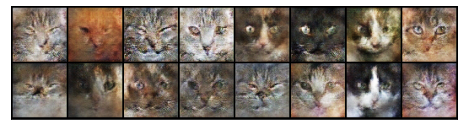

Epoch [187/200], Batch [1/10], loss_g: 4.5444, loss_d: 0.1071
Epoch [187/200], Batch [2/10], loss_g: 5.0313, loss_d: 0.0459
Epoch [187/200], Batch [3/10], loss_g: 7.5240, loss_d: 0.2574
Epoch [187/200], Batch [4/10], loss_g: 5.9169, loss_d: 0.2417
Epoch [187/200], Batch [5/10], loss_g: 4.0572, loss_d: 0.0851
Epoch [187/200], Batch [6/10], loss_g: 5.0619, loss_d: 0.1173
Epoch [187/200], Batch [7/10], loss_g: 6.0981, loss_d: 0.1170
Epoch [187/200], Batch [8/10], loss_g: 4.3532, loss_d: 0.1292
Epoch [187/200], Batch [9/10], loss_g: 4.4388, loss_d: 0.0744
Epoch [187/200], Batch [10/10], loss_g: 4.6556, loss_d: 0.0444
Saving generated-image-0251.png
Epoch [188/200], Batch [1/10], loss_g: 12.3596, loss_d: 0.5916
Epoch [188/200], Batch [2/10], loss_g: 5.3005, loss_d: 2.6599
Epoch [188/200], Batch [3/10], loss_g: 6.4005, loss_d: 0.4551
Epoch [188/200], Batch [4/10], loss_g: 6.2444, loss_d: 0.0913
Epoch [188/200], Batch [5/10], loss_g: 5.0731, loss_d: 0.1972
Epoch [188/200], Batch [6/10], loss_

<Figure size 432x288 with 0 Axes>

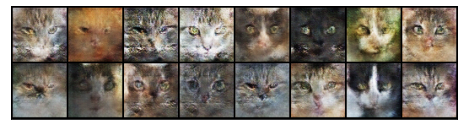

Epoch [197/200], Batch [1/10], loss_g: 4.2234, loss_d: 0.0869
Epoch [197/200], Batch [2/10], loss_g: 5.6805, loss_d: 0.1520
Epoch [197/200], Batch [3/10], loss_g: 4.9261, loss_d: 0.1448
Epoch [197/200], Batch [4/10], loss_g: 4.9424, loss_d: 0.0827
Epoch [197/200], Batch [5/10], loss_g: 4.6158, loss_d: 0.0783
Epoch [197/200], Batch [6/10], loss_g: 4.5762, loss_d: 0.1341
Epoch [197/200], Batch [7/10], loss_g: 4.9263, loss_d: 0.1158
Epoch [197/200], Batch [8/10], loss_g: 4.6471, loss_d: 0.0967
Epoch [197/200], Batch [9/10], loss_g: 3.5607, loss_d: 0.1465
Epoch [197/200], Batch [10/10], loss_g: 5.3766, loss_d: 0.1500
Saving generated-image-0261.png
Epoch [198/200], Batch [1/10], loss_g: 5.1273, loss_d: 0.1489
Epoch [198/200], Batch [2/10], loss_g: 4.5300, loss_d: 0.1123
Epoch [198/200], Batch [3/10], loss_g: 4.9668, loss_d: 0.0486
Epoch [198/200], Batch [4/10], loss_g: 8.4352, loss_d: 0.3752
Epoch [198/200], Batch [5/10], loss_g: 5.0157, loss_d: 0.5699
Epoch [198/200], Batch [6/10], loss_g

In [16]:
opt_d = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) 

if (OLD_MODEL_EXISTS):
    discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
    generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

for epoch in range(NUM_EPOCHS):
    num_batches = len(real_dataloader)
    
    for batch_number, (real_images, _) in enumerate(real_dataloader):
        loss_d, _, _ = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_number+1}/{num_batches}], loss_g: {loss_g:.4f}, loss_d: {loss_d:.4f}")
        
    save_samples(epoch+1+START_INDEX, fixed_latent, show=True)
    torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
    torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")


In [ ]:
torch.save(discriminator.state_dict(), MODEL_PATH + "discriminator.pt")
torch.save(generator.state_dict(), MODEL_PATH + "generator.pt")

In [ ]:
discriminator.load_state_dict(torch.load(MODEL_PATH + "discriminator.pt"))
generator.load_state_dict(torch.load(MODEL_PATH + "generator.pt"))

<All keys matched successfully>